Due to the current situation (`Updated 09/02/2026`),

- Google Gemini has reduced the rate limits for several models, such as `gemini-2.5-flash` and `gemini-3-flash` (text models used in Colab notebooks), to a **limit of 20 Requests Per Day (RPD)**.

- To continue using these models seamlessly with sufficient rate limits, it is necessary to upgrade to the **pay-as-you-go tier** (link a Billing Account).
  - 👉 You can learn how to do this here: [https://ai.google.dev/gemini-api/docs/billing](https://ai.google.dev/gemini-api/docs/billing)

- Alternatively, you can follow the Groq API approach described below.


# RAG Demo
Note: Code mostly copied from LangChain's tutorial https://python.langchain.com/docs/tutorials/rag/

This tutorial will show you how to implement a simple RAG pipeline.

# Setup

In [1]:
%%capture
!pip install -qU langchain
!pip install -qU langchain-huggingface
!pip install -qU langchain-chroma
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install -qU pypdf
!pip install -q fixthaipdf
!pip install sentence-transformers

(Optional) — Run the code below to enable text wrapping in the output block for better readability.

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Code

## Components

LLM (a part of generation)
- used for generating the final answer to the user's question, by taking the retrieved context and the question as input.

### Approach 1: Gemini

In [3]:
# %%capture
# !pip install -qU langchain-google-genai

Request for Google API KEY here : https://aistudio.google.com/app/apikey

In [4]:
# from getpass
# import os

# os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [5]:
# from langchain_google_genai import ChatGoogleGenerativeAI

# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.5-flash",
#     temperature=0.7,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     # other params...
# )

### Approach 2: Groq API


However, we still have an **alternative** that can be used via a free-tier API: **Groq API** (compatible with LangChain). This does not require linking a credit card and offers several models, such as:

- `llama-3.1-8b-instant` (Rate limit: 30 RPM, 14.4K RPD) *RPM = Requests Per Minute, RPD = Requests Per Day
- `llama-3.3-70b-versatile` (Rate limit: 30 RPM, 1K RPD)
- Other available models: https://console.groq.com/settings/limits

*(RPM = Requests Per Minute, TPM = Tokens Per Minute)*

👉 You can sign up and get your API Key here: [https://console.groq.com/keys](https://console.groq.com/keys)


In [6]:
!pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 6.6 MB/s eta 0:00:00


In [7]:
import getpass
import os

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key: ··········


Since this is an open-ended generation, we do not want the generation to be boring so temperature is set to 1 instead of 0.

In [8]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant", # can change
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

Embedding Model (a part of retrieval)
- The HuggingFaceEmbeddings(`model_name="BAAI/bge-m3"`) is used to convert the text documents (and user queries) into numerical vector representations (embeddings).
- These embeddings capture the semantic meaning of the text, allowing for similarity comparisons.

In [9]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Vector Database (a part of retrieval)
- `Chroma` serves as the vector database. Its purpose is to store the embeddings generated from the document chunks and enable efficient similarity searches.
- When a user asks a question, `its embedding` is compared against the `stored document embeddings` to find the most relevant document chunks.

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

## Retrieval

To build a retrieval part, it contains 3 steps :
- (1) Load a Document --> (2) Splitting --> (3) Storing

### Loading a Document

We will be using CR99 from Reg Chula as our document. To load this pdf, we will use `PyPDFLoader`.

You can download the document here (choose only one):
- Thai Version: https://www.reg.chula.ac.th/CR99_2025_Th.pdf
- Eng Version: https://web.reg.chula.ac.th/CR99_2023_EngS.pdf


In [11]:
!wget https://web.reg.chula.ac.th/CR99_2023_EngS.pdf --no-check-certificate # eng ver.

--2026-02-09 15:05:28--  https://web.reg.chula.ac.th/CR99_2023_EngS.pdf
Resolving web.reg.chula.ac.th (web.reg.chula.ac.th)... 161.200.133.230
Connecting to web.reg.chula.ac.th (web.reg.chula.ac.th)|161.200.133.230|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1670989 (1.6M) [application/pdf]
Saving to: ‘CR99_2023_EngS.pdf’

CR99_2023_EngS.pdf  100%[===================>]   1.59M  9.47MB/s    in 0.2s    

2026-02-09 15:05:30 (9.47 MB/s) - ‘CR99_2023_EngS.pdf’ saved [1670989/1670989]



In [12]:
file_name = "CR99_2023_EngS" # @param {"type":"string"}
from langchain_community.document_loaders import PyPDFLoader
from fixthaipdf import clean

file_path = (
    f"/content/{file_name}.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

pages[0]

Document(metadata={'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2023-09-22T15:10:46+07:00', 'author': 'Office of the Registrar', 'moddate': '2023-09-22T16:11:28+07:00', 'title': '', 'source': '/content/CR99_2023_EngS.pdf', 'total_pages': 35, 'page': 0, 'page_label': '1'}, page_content='CR99\nStudent Registration Manual\nAcademic Year 2023')

In [13]:
for page in pages:
  page.page_content = clean(page.page_content)

In [14]:
print(pages[1])

page_content='The Student Registration Manual is compiled by the Office of the Registrar to provide
both undergraduate and graduate students understanding in processes involved in student
registration, starting from their first enrollment into Chulalongkorn University up until to their
graduation. It contains guideline on registration process, required documents, schedules,
and contact information.
Nevertheless, throughout the academic year, it is possible that there might be some
change in details regardi ng registration processs. It is highly recommended that all students
should follow latest information, procedures, or schedule at the Office of the Registrar’s
website (https://www.reg.chula.ac.th) regularly to ensure that they do not miss the deadline
or any steps in registration.
We hope that this manual will be of use throughout your study in Chulalongkorn
University.
Contact Us
Location Chamchuri 6 Building
Time Office Hours: 8:00 AM – 5:00 PM (Mon. – Fri.)
Payment Hours: 8:00 AM

### Splitting documents

Our loaded document is too long to fit
into the context window of many models. Even for those models that could
fit the full post in their context window, models can struggle to find
information in very long inputs.

To handle this we’ll split the `Document`s into chunks for embedding and
vector storage. This should help us retrieve only the most relevant parts
of the blog post at run time.

We use a
[RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),
which will recursively split the document using common separators like
new lines until each chunk is the appropriate size. This is the
recommended text splitter for generic text use cases.

In [15]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # chunk size (characters)
    chunk_overlap=200,      # chunk overlap (characters)
    add_start_index=True,   # track index in original document
)
all_splits = text_splitter.split_documents(pages)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 87 sub-documents.


### Storing documents

Now we need to index our text chunks so that we can search over them
at runtime. Our approach is to [embed](https://python.langchain.com/docs/concepts/embedding_models/) the contents of each document split and insert these embeddings
into a [vector store](https://python.langchain.com/docs/concepts/vectorstores/). Given an input query, we can then use
vector search to retrieve relevant documents.

We can embed and store all of our document splits in a single command
using the vector store and embeddings model selected at the [start of the tutorial](https://python.langchain.com/docs/tutorials/rag/#components).

In [16]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['59043295-a7ba-4993-af50-6718e0a15c7b', '6d5bc802-1c2c-4410-8c50-e1a4bb6c9da8', '156e6300-a747-4896-bbf0-a0464efde107']


### Test our Vector Database (Retrieval Part)

- When you provide a query (like 'Loss my student card') it performs a similarity search to find and return the most relevant document chunks based on their meaning, not just keyword matches.
- This retrieval capability is the foundation for a complete RAG pipeline. The next step, as you mentioned, would be to integrate an LLM to generate a coherent answer based on these retrieved documents and the original query.

- Ex. query = "Loss a Student Card"

In [17]:
query = "What should I do if I lose my student card?"
retrieved_docs = vector_store.similarity_search(query)

print(f"Query: {query}\n")
print("Retrieved Documents:")
print("="*50)
for i, doc in enumerate(retrieved_docs):
    print(f"-- Document Relevance Rank no. {i+1} --")
    print(f"Content: {doc.page_content}...") # Print first 500 characters
    print(f"Metadata: {doc.metadata}\n")
    print("="*50)

Query: What should I do if I lose my student card?

Retrieved Documents:
-- Document Relevance Rank no. 1 --
Content: Student Card
Chulalongkorn University in cooperation with Kasikorn Bank (KBank) will issue student cards for
every new students in their first semester. Following are benefits and privileges of the student card:
1. Identifying oneself as a student of the University to gain access to libraries and other facilities
of the University such as CU Health Service Center and CU Sports Complex.
2. Student card will also serve as a debit card of KBank. No application or annual fee is charged
throughout the period of study at Chulalongkorn University.
3. Other privileges as announced by Kasikorn Bank.
Request for Replacement of Student Card
Request for replacement of student card due to defect, loss, expiration, or name change can
be done by 3 methods.
 Request at the Office of the Registrar
1. Submit CR50 form and pay 100 baht fee at the Office of the Registrar
2. Bring the foll

## Retrieval and Generation
- We now have the retrieval component (vector database). Next, we need to add the generation component (LLM) to complete the RAG pipeline.

- The application will:
  - Take a user question `[Input]`
  - Search for documents relevant to that question `[Retrieval]`
  - Pass the retrieved documents and the original question to a model `[Augmented]`
  - Return the generated answer `[Generation]`

- For generation, we will use the chat model selected at the beginning of this notebook.
- We’ll use a RAG prompt template published in the LangChain Prompt Hub ([here](https://smith.langchain.com/hub/rlm/rag-prompt)).

Note: LangSmith API key is required for pulling the prompt from hub.

- LangSmith API Key : [smith.langchain.com](https://smith.langchain.com)


In [18]:
# langsmith API key for pulling prompt template
import os
from getpass import getpass
LANGSMITH_API_KEY=getpass("LANGSMITH_API_KEY:")

LANGSMITH_API_KEY:··········


Pull and see the prompt template we will use

In [19]:
from langsmith import Client
client = Client(api_key=LANGSMITH_API_KEY)
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/).
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) and [human-in-the-loop approval](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/), with minimal code changes.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

### State

The [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a `TypedDict`, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/).

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [20]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Nodes (application steps)

Let's start with a simple sequence of two steps: retrieval and generation.

In [21]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

### Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [22]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

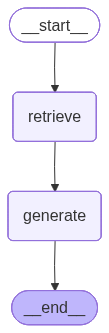

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Usage

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

Invoke:

In [24]:
question = "What should I do if I loss my student card?"

In [25]:
result = graph.invoke({"question": question})

print(f'Context: {result["context"][0]}\n\n')
print(f'Answer: {result["answer"]}')

Context: page_content='Student Card
Chulalongkorn University in cooperation with Kasikorn Bank (KBank) will issue student cards for
every new students in their first semester. Following are benefits and privileges of the student card:
1. Identifying oneself as a student of the University to gain access to libraries and other facilities
of the University such as CU Health Service Center and CU Sports Complex.
2. Student card will also serve as a debit card of KBank. No application or annual fee is charged
throughout the period of study at Chulalongkorn University.
3. Other privileges as announced by Kasikorn Bank.
Request for Replacement of Student Card
Request for replacement of student card due to defect, loss, expiration, or name change can
be done by 3 methods.
 Request at the Office of the Registrar
1. Submit CR50 form and pay 100 baht fee at the Office of the Registrar
2. Bring the following documents to 2 branches of Kasikorn Bank (Chamchuri Square or' metadata={'creationdate': 

Stream steps:

In [26]:
for step in graph.stream(
    {"question": question}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='498c8c5e-193c-4248-8f81-8ff0d8c35b18', metadata={'creator': 'Microsoft® Word 2013', 'creationdate': '2023-09-22T15:10:46+07:00', 'source': '/content/CR99_2023_EngS.pdf', 'moddate': '2023-09-22T16:11:28+07:00', 'author': 'Office of the Registrar', 'page': 9, 'page_label': '10', 'start_index': 0, 'producer': 'Microsoft® Word 2013', 'title': '', 'total_pages': 35}, page_content='Student Card\nChulalongkorn University in cooperation with Kasikorn Bank (KBank) will issue student cards for\nevery new students in their first semester. Following are benefits and privileges of the student card:\n1. Identifying oneself as a student of the University to gain access to libraries and other facilities\nof the University such as CU Health Service Center and CU Sports Complex.\n2. Student card will also serve as a debit card of KBank. No application or annual fee is charged\nthroughout the period of study at Chulalongkorn University.\n3. Other privileges as annou

# Agentic RAG
In a normal RAG pipeline, the workflow is linear (see the `Control Flow Section` above — retrieve documents, then generate an answer.

Agentic RAG makes the RAG process more intelligent.
Instead of following a fixed, linear flow, the LLM can dynamically decide:
- What to query – it can rewrite the user’s question into a more effective search query.
- What tools to use – it can understand the user’s intent and choose the right tool.
- What to do next – it can decide whether to use another tool or stop, depending on the conversation.

### State

To make the stage management more structure and easier, we can use prebuilt stage management from LangGraph that's called `MessagesState`.

It’s similar to the custom stage function we created in the simple RAG example, but it organizes the conversation into three main message types: `HumanMessage`, `AIMessage`, and `ToolMessage`

Conversation Flow:
  1. `HumanMessage` – the user’s question
  2. `AIMessage` (tool call) – the model decides to search or use a tool or terminate.
  This may include rewriting the user’s query into a more effective search query.
  3. `ToolMessage` – the retrieved documents or tool results.
  4. `AIMessage` – the final answer from the model..

In [27]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState) # Just one line instead of manual custom state function

### Node

Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
2. A node for the retriever tool that executes the retrieval step;
3. A node that generates the final response using the retrieved context.

We build them below. Note that we leverage another pre-built LangGraph component, [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode), that executes the tool and adds the result as a `ToolMessage` to the state.

In [28]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [29]:
# Step 2A: Retrieval Node
from langchain_core.tools import tool

@tool # Marks this function as a Tool; its outputs will appear as ToolMessages (message.type == "tool")
def retrieve(query: str):
    """Retrieve information related to a query from a vector database containing information on student's handbook."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


Register the retrieval function as a ToolNode so that the agent recognizes it as a tool and can intelligently decide whether to perform a search (use the tool) or terminate, instead of following a strictly linear workflow.

In [30]:
# Step 2B Register a Tool (Retrieval) as ToolNode
tools = ToolNode([retrieve])

In [31]:
# Step 3: Generation Node
def generate(state: MessagesState):
    """Generate answer."""
    # Collect recent ToolMessages from the conversation state.
    # (These messages store the outputs returned by any tools the agent used.)
    recent_tool_messages = []

    # Loop backward through the message list (from newest to oldest).
    # Stop once we hit the first non-tool message.
    for message in reversed(state["messages"]):
        if message.type == "tool": # "tool" marks messages generated by @tool functions
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    #  Format the retrieved tool outputs into a prompt for the LLM
    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    # Build the system message that tells the model how to behave
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}" # p
    )

    # Keep only human, system, and normal AI messages.
    # (We exclude tool call messages since their outputs are already gathered in docs_content.)
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    # Combine system message + conversation history into a full prompt
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

- Finally, we compile our application into a single `graph` object.
- In this case, we are just connecting the steps into a sequence. We also allow the first `query_or_respond` step to "short-circuit" and respond directly to the user if it does not generate a tool call.
- This allows our application to support conversational experiences-- e.g., responding to generic greetings that may not require a retrieval step

### Control Flow

In [32]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

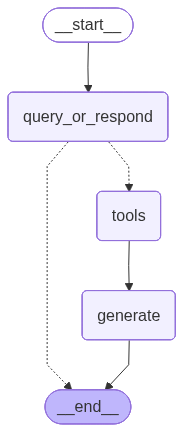

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Stateful management of chat history (Multi-turn Conversation)

To manage mult-turn conversations, all we have to do is specify a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/) when compiling our application. Because the nodes in our graph are appending messages to the state, we will retain a consistent chat history across invocations.

LangGraph comes with a simple in-memory checkpointer, which we use below. See its [documentation](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

For a detailed walkthrough of how to manage message history, head to the [How to add message history (memory)](/docs/how_to/message_history) guide.

In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() # to support multi-turn conversation
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test01"}}

We can now invoke similar to before:

In [35]:
input_message = "What should I do if I loss my student card?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config, # our checkpointer
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What should I do if I loss my student card?
================================== Ai Message ==================================
Tool Calls:
  retrieve (djrmgxb8y)
 Call ID: djrmgxb8y
  Args:
    query: what to do if lost student card
================================= Tool Message =================================
Name: retrieve

("Source: {'page': 9, 'source': '/content/CR99_2023_EngS.pdf', 'title': '', 'start_index': 0, 'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'author': 'Office of the Registrar', 'total_pages': 35, 'page_label': '10', 'moddate': '2023-09-22T16:11:28+07:00', 'creationdate': '2023-09-22T15:10:46+07:00'}\nContent: Student Card\nChulalongkorn University in cooperation with Kasikorn Bank (KBank) will issue student cards for\nevery new students in their first semester. Following are benefits and privileges of the student card:\n1. Identifying oneself as a student of 

You can notice a small difference between the human’s query and the AI’s query (tool calling).
  - Human: `What should I do if I lose my student card?`
  - AI: `what to do if I lose my student card`

(The results may vary across different runs.)

Test: Multi-turn Conversation

In [36]:
input_message = "Which Kasikorn Bank branches can I go to?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which Kasikorn Bank branches can I go to?
================================== Ai Message ==================================
Tool Calls:
  retrieve (cpby08q8j)
 Call ID: cpby08q8j
  Args:
    query: Kasikorn Bank branches to replace student card
================================= Tool Message =================================
Name: retrieve

("Source: {'title': '', 'source': '/content/CR99_2023_EngS.pdf', 'start_index': 0, 'creationdate': '2023-09-22T15:10:46+07:00', 'author': 'Office of the Registrar', 'page_label': '10', 'total_pages': 35, 'producer': 'Microsoft® Word 2013', 'moddate': '2023-09-22T16:11:28+07:00', 'page': 9, 'creator': 'Microsoft® Word 2013'}\nContent: Student Card\nChulalongkorn University in cooperation with Kasikorn Bank (KBank) will issue student cards for\nevery new students in their first semester. Following are benefits and privileges of the student card:\n1. Identifying oneself as 

- You can notice that the AI’s query is `Kasikorn Bank branches for student card replacement`.
- Student card replacement is still recognized even though it’s not mentioned in the turn-2 query. (turn-2 query from human is `Which Kasikorn Bank branches can I go to?
`.